In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.time import Time, TimeDelta
import lsst.sims.downtimeModel as dt
import lsst.sims.cloudModel as cm

In [2]:
tstart = Time('2022-10-01', format='isot', scale='tai')
day_offset = TimeDelta(-0.34, format='jd')

In [3]:
# Read scheduled downtime data.
scheduledDowntimeData = dt.ScheduledDowntimeData(tstart, start_of_night_offset=day_offset)
scheduledDowntimeData.read_data()

print(len(scheduledDowntimeData.downtime))
print("First downtime", "start", scheduledDowntimeData.downtime[0]['start'].isot, 
      "end", scheduledDowntimeData.downtime[0]['end'].isot)
print("Last downtime", "start", scheduledDowntimeData.downtime[-1]['start'].isot, 
      "end", scheduledDowntimeData.downtime[-1]['end'].isot)

31
First downtime start 2022-06-07T15:50:24.000 end 2022-06-14T15:50:24.000
Last downtime start 2041-10-29T15:50:24.000 end 2041-11-05T15:50:24.000


In [4]:
# Read (generate) unscheduled downtime data
unscheduledDowntimeData = dt.UnscheduledDowntimeData(tstart, start_of_night_offset=day_offset,
                                                    survey_length=3650*2, seed=3)
unscheduledDowntimeData.make_data()

print(len(unscheduledDowntimeData.downtime))
print(unscheduledDowntimeData.downtime[0])

145
(<Time object: scale='tai' format='isot' value=2022-03-01T15:50:24.000>, <Time object: scale='tai' format='isot' value=2022-03-02T15:50:24.000>, 'minor event')


In [5]:
# Read cloud data
cloudData = cm.CloudData(tstart)
cloudData.read_data()

In [6]:
# Set up downtime model
dtModel = dt.DowntimeModel()
dtModel.config_info()

OrderedDict([('DowntimeModel_version', '0bec6a0'),
             ('DowntimeModel_sha', '0bec6a04497600aa71a01ebe8d9343335ed55342'),
             ('efd_columns', ['scheduled_downtimes', 'unscheduled_downtimes']),
             ('efd_delta_time', 0.0),
             ('target_columns', ['time'])])

In [7]:
# Set up cloud model
cloudModel = cm.CloudModel()
cloudModel.config_info()

OrderedDict([('CloudModel_version', 'unknown'),
             ('CloudModel_sha', '73e205387426ea256f6a3cb809fe8ddccddb22b1 *'),
             ('efd_columns', ['cloud']),
             ('efd_delta_time', 0.0),
             ('target_columns', ['altitude', 'azimuth'])])

In [8]:
# The EFD data for the downtime models is a little different than some of the other *Data values.
# Basically, you don't repeatedly query it (although that may make sense in production),
# and then you just pass the entire downtime arrays into the model.
sched_downtime = scheduledDowntimeData()
unsched_downtime = unscheduledDowntimeData()
efdData = {'scheduled_downtimes': sched_downtime,
           'unscheduled_downtimes': unsched_downtime}
# But for the cloud model, the efdData is the cloud (single value, because we don't have sky maps yet)
# value at that time.
# i.e  efdData.update(cloudData(t))

In [13]:
# So let's look at what we would see as a result of asking about 'downtime' and 'cloud' once per day for 10 years
t = tstart
efdData = {'scheduled_downtimes': sched_downtime,
           'unscheduled_downtimes': unsched_downtime}

tend = Time('2033-10-01', format='isot', scale='tai')
tStep = TimeDelta(1, format='jd')
times = np.arange(tstart, tend, tStep)
cloudstatus = np.zeros(len(times), bool)  # True = closed / downtime
telestatus = np.zeros(len(times), bool)   # True = closed
for i, t in enumerate(times):
    efdData['cloud'] = cloudData(t)
    targetDict = {'time': t, 'altitude': np.array([90]), 'azimuth': np.array([0])}
    down = dtModel(efdData, targetDict)
    telestatus[i] = down['status']
    cloud = cloudModel(efdData, targetDict)
    if cloud['cloud'][0] > 0.3:
        cloudstatus[i] = True

In [14]:
len(np.where(cloudstatus)[0]), len(np.where(telestatus)[0]), len(np.where(telestatus & cloudstatus)[0])

(1104, 322, 127)

(0, 1.1)

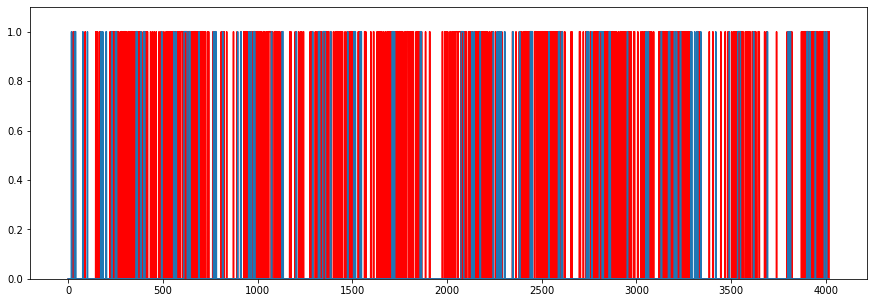

In [21]:
plt.figure(figsize=(15, 5))
plt.plot(cloudstatus, color='r')
plt.plot(telestatus)
plt.ylim(0, 1.1)

In [24]:
(len(times) - len(np.where(cloudstatus)[0]))/10

291.4